#### Busqueda tipo waze/google maps

Nuestro objetivo es crear una heuristica creativa y util para  encontrar la mejor ruta entre dos lugares del municipio de Envigado   
Priemero haremos la definición de nuestro grafo 

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
import plotly_express as px

import networkx as nx
import osmnx as ox

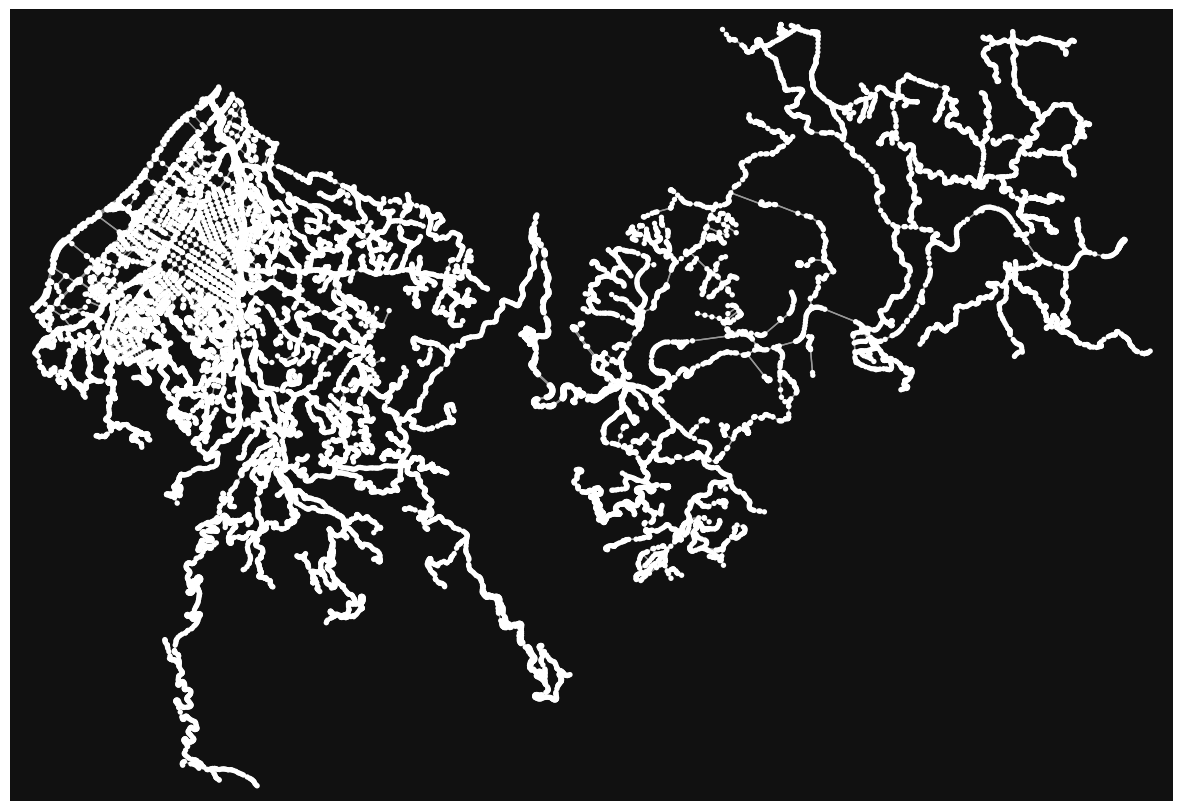

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [13]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive', simplify=False)
ox.plot_graph(G,figsize=(15,15))

Con esta función graph to *graph_to_gdfs(G)* traemos los nodos y aristas de nuestro grafo como un DF

In [14]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [15]:
gdf_edges.head()

osmid    highway lanes maxspeed  \
u         v          key                                         
309313450 414940715  0    1019189334  secondary     2       50   
          440765240  0    1019189334  secondary     2       50   
309313451 414940727  0    1019189334  secondary     2       50   
          414940715  0    1019189334  secondary     2       50   
309313454 4124260034 0    1019190824  secondary     2       60   

                                         name  oneway  reversed     length  \
u         v          key                                                     
309313450 414940715  0    Variante Las Palmas   False     False  24.138083   
          440765240  0    Variante Las Palmas   False      True  91.294214   
309313451 414940727  0    Variante Las Palmas   False     False  26.537531   
          414940715  0    Variante Las Palmas   False      True  27.314193   
309313454 4124260034 0    Variante Las Palmas   False     False  25.381809   

                          ref width junction bridge access  \
u         v          key                                     
309313450 414940715  0    NaN   NaN      NaN    NaN    NaN   
          440765240  0    NaN   NaN      NaN    NaN    NaN   
309313451 414940727  0    NaN   NaN      NaN    NaN    NaN   
          414940715  0    NaN   NaN      NaN    NaN    NaN   
309313454 4124260034 0    NaN   NaN      NaN    NaN    NaN   

                                                                   geometry  
u         v          key                                                     
309313450 414940715  0    LINESTRING (-75.51982 6.15843, -75.52004 6.15839)  
          440765240  0    LINESTRING (-75.51982 6.15843, -75.51903 6.15866)  
309313451 414940727  0     LINESTRING (-75.52028 6.1584, -75.52051 6.15847)  
          414940715  0     LINESTRING (-75.52028 6.1584, -75.52004 6.15839)  
309313454 4124260034 0     LINESTRING (-75.5215 6.15963, -75.52164 6.15981)

### Manipulación del Df
Debemos tener las variables necesarias para poder hacer nuestra heuristica 

1. Vamos a llenar todas las velocidades para poder crear el travel time 


In [137]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 37238 entries, (np.int64(309313450), np.int64(414940715), np.int64(0)) to (np.int64(13050291096), np.int64(1863096087), np.int64(0))
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   osmid        37238 non-null  int64   
 1   highway      37238 non-null  object  
 2   lanes        8580 non-null   object  
 3   maxspeed     4364 non-null   object  
 4   name         15637 non-null  object  
 5   oneway       37238 non-null  bool    
 6   reversed     37238 non-null  bool    
 7   length       37238 non-null  float64 
 8   speed_kph    37238 non-null  float64 
 9   travel_time  37238 non-null  float64 
 10  ref          828 non-null    object  
 11  width        570 non-null    object  
 12  junction     314 non-null    object  
 13  bridge       208 non-null    object  
 14  access       58 non-null     object  
 15  geometry     37238 non-null  geometry
dt

2. Vamos a añadir la elevación de las aristas

In [ ]:
# G = ox.elevation.add_node_elevations_raster(G)
# G = ox.elevation.add_edge_grades(G, add_absolute=True)
# gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
# gdf_edges.head()


2. Importamos el tipo de superficie y la añadimos a nuestro DF 

In [138]:
gdf_surface = ox.features.features_from_place("Envigado, Antioquia, Colombia", tags={'surface': True})

gdf_edgesMod= gpd.sjoin(
    gdf_edges,
    gdf_surface[['surface', 'geometry']],
    how='left',
    predicate='intersects'
)

gdf_edgesMod['surface'] = gdf_edgesMod['surface'].fillna('asphalt')

In [139]:
tipos_de_superficie = gdf_edgesMod['surface'].dropna().unique()
print("Tipos únicos de superficie encontrados:")
for tipo in sorted(tipos_de_superficie):
    print("-", tipo)
 
# Conteo por tipo de superficie
conteo = gdf_edgesMod['surface'].value_counts(dropna=False)
print(conteo)


Tipos únicos de superficie encontrados:
- asphalt
- cobblestone
- concrete
- concrete:lanes
- concrete:plates
- dirt
- fine_gravel
- gravel
- ground
- paved
- paving_stones
- unpaved
surface
asphalt            41189
unpaved             2944
paved               2268
gravel               245
concrete             210
concrete:lanes        64
paving_stones         52
cobblestone           18
ground                 6
concrete:plates        4
dirt                   4
fine_gravel            2
Name: count, dtype: int64


In [ ]:
surface_weights = {
    'asphalt': 1.0,             
    'concrete': 1.1,
    'concrete:lanes': 1.1,
    'concrete:plates': 1.2,
    'paved': 1.2,
    'paving_stones': 1.4,
    'fine_gravel': 1.6,
    'gravel': 2.0,
    'cobblestone': 2.2,
    'ground': 2.5,
    'dirt': 3.0,
    'unpaved': 2.8,
    'unknown': 4 # neutro si no sabemos qué es
}

def surface_weight(u, v, k, data):
    surface = data.get('surface', 'unknown')
    length = data.get('length', 1)
    factor = surface_weights.get(surface)

    peso = length * factor
    print(f"De {u} a {v}: superficie={surface}, long={length}, factor={factor}, peso={peso}")
    return peso



In [124]:
import geopy
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent='myGeocoder')

In [125]:
location_start = locator.geocode('Viva Envigado, Envigado, Colombia')
location_end=locator.geocode(' Sede Posgrados Eia, Colombia')
print(location_start.latitude, location_start.longitude)

6.1762915 -75.5916923


De 4404924416 a 5532256386: superficie=unknown, long=10.240316274148162, factor=4, peso=40.96126509659265
De 4404924416 a 340686061: superficie=unknown, long=9.52990009854489, factor=4, peso=38.11960039417956
De 9694411267 a 2417951905: superficie=unknown, long=9.092140335706803, factor=4, peso=36.36856134282721
De 3914597902 a 569685702: superficie=unknown, long=44.401805450128556, factor=4, peso=177.60722180051422
De 3914597902 a 3914597905: superficie=unknown, long=26.605764022891876, factor=4, peso=106.4230560915675
De 6133988880 a 6133988882: superficie=unknown, long=14.521229725588947, factor=4, peso=58.08491890235579
De 3914597905 a 3914597902: superficie=unknown, long=26.605764022891876, factor=4, peso=106.4230560915675
De 3914597905 a 3914597906: superficie=unknown, long=58.58373032254047, factor=4, peso=234.33492129016187
De 3914597906 a 3914597905: superficie=unknown, long=58.58373032254047, factor=4, peso=234.33492129016187
De 3914597906 a 10330225257: superficie=unknown, l

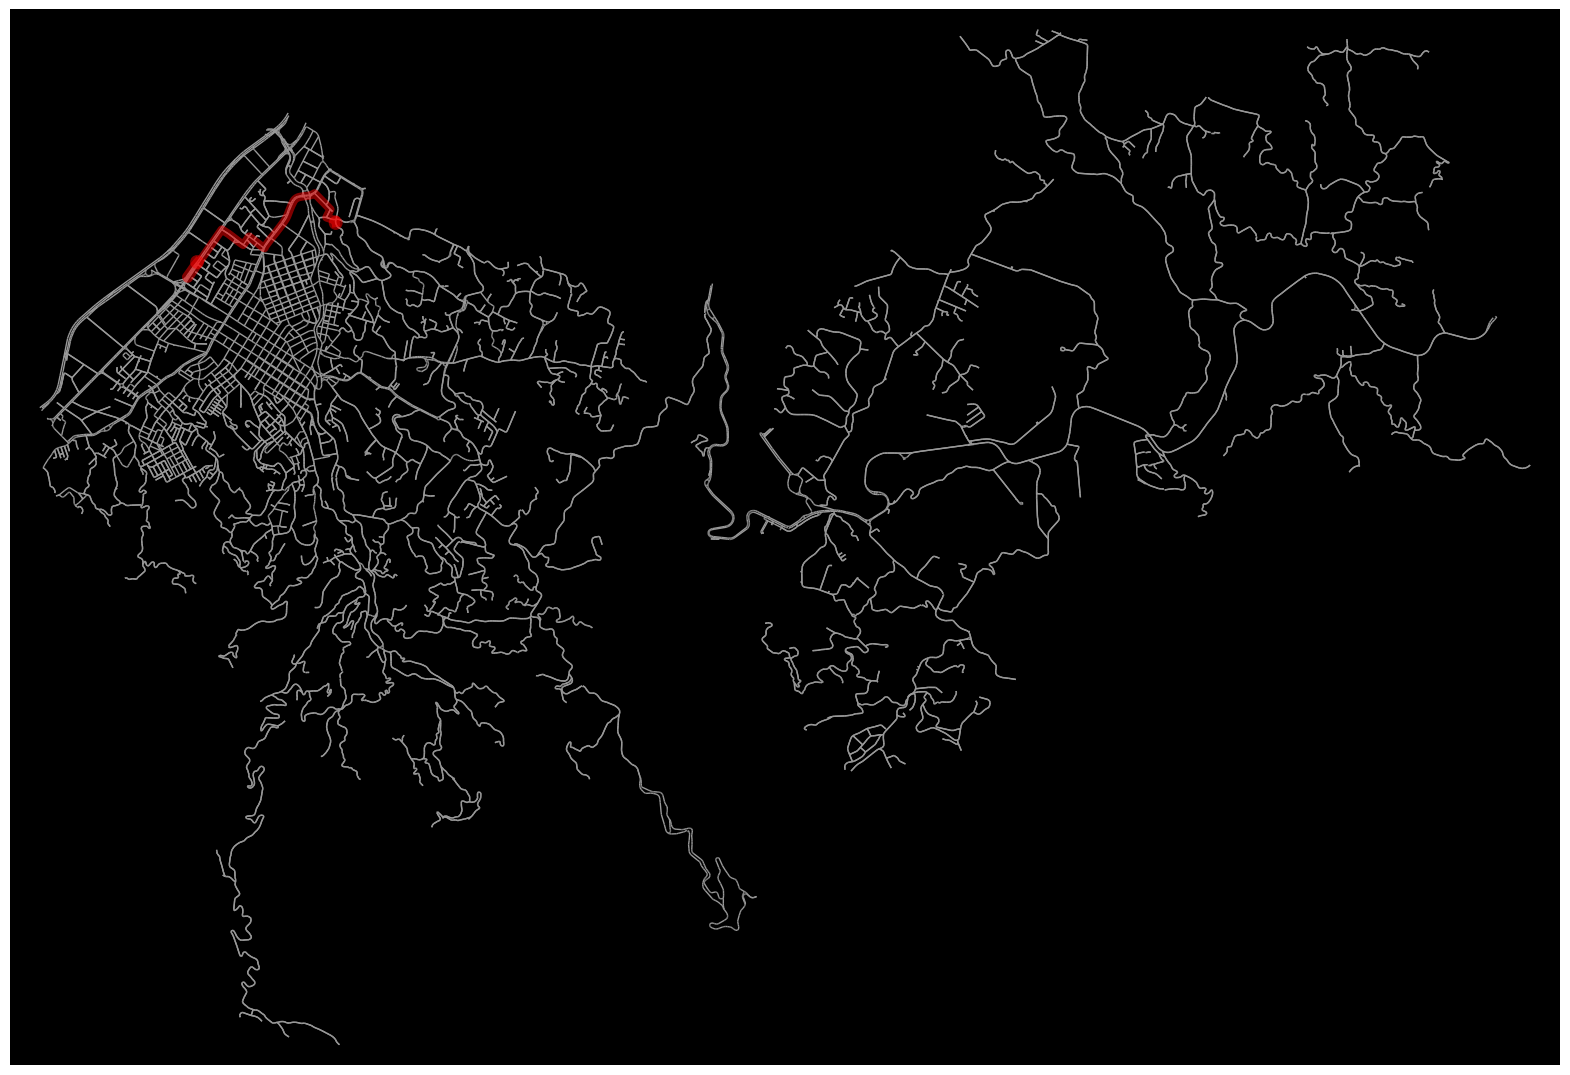

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

In [126]:
start= (location_start.latitude, location_start.longitude)
end= (location_end.latitude, location_end.longitude)
start_node = ox.distance.nearest_nodes(G, start[1],start[0])
end_node = ox.distance.nearest_nodes(G, end[1],end[0])



route1 = nx.shortest_path(G, start_node, end_node, weight='surface_weight')

costo_total = sum(
    surface_weight(u, v, k, data)
    for u, v, k, data in G.subgraph(route1).edges(keys=True, data=True)
)

print("Costo total ajustado por superficie:", costo_total)

ox.plot_graph_route(G, route1, route_linewidth=6, node_size=0, bgcolor='k',figsize=(20, 20))

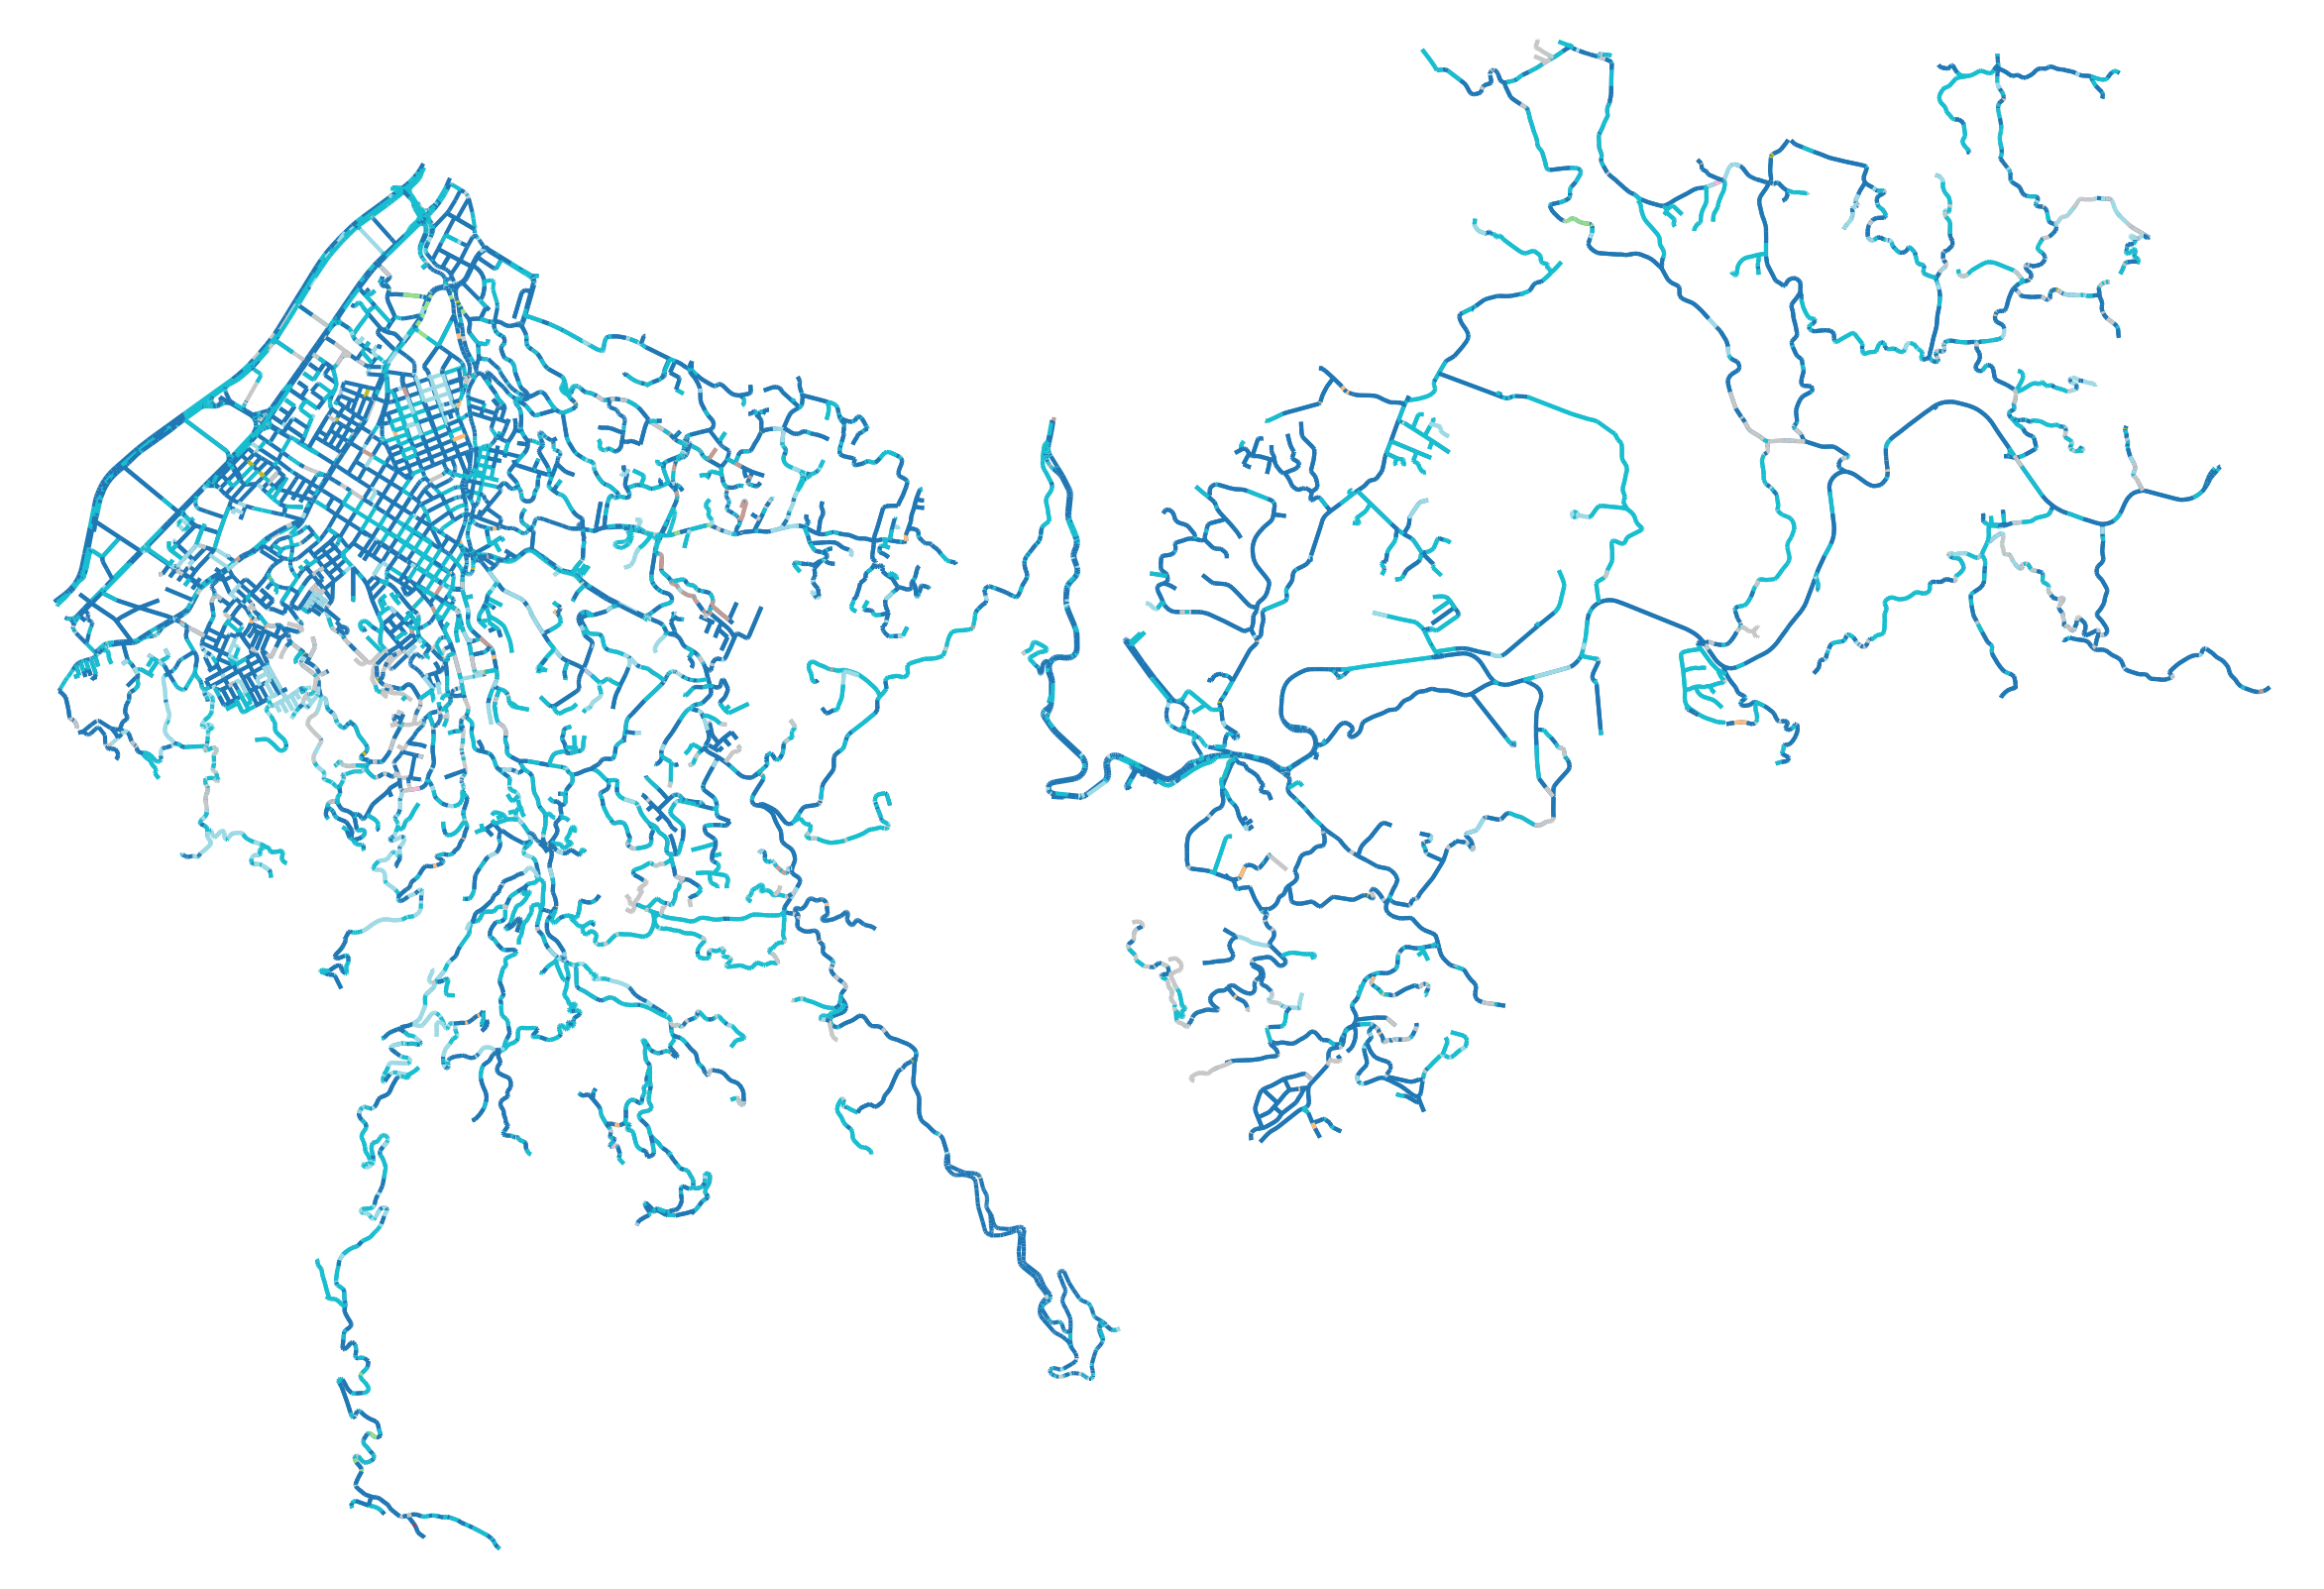

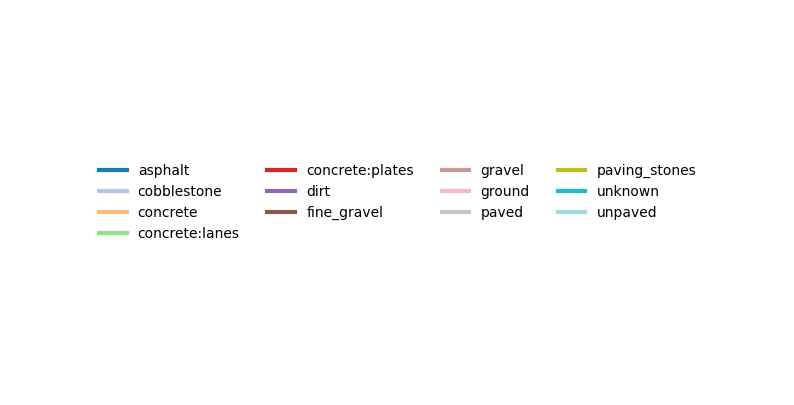

In [98]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import osmnx as ox

# Extraer los tipos únicos de superficie para asignar colores
surfaces = list(gdf_edgesMod['surface'].fillna('unknown').unique())
surfaces.sort()

# Crear un mapa de colores personalizado
color_map = plt.get_cmap("tab20", len(surfaces))
surface_color_dict = {surf: color_map(i) for i, surf in enumerate(surfaces)}

# Asignar color a cada arista según su superficie
edge_colors = gdf_edgesMod['surface'].fillna('unknown').map(surface_color_dict)

# Dibujar el grafo
fig, ax = ox.plot_graph(G,
                        edge_color=edge_colors.tolist(),
                        edge_linewidth=3,
                        node_size=0,
                        bgcolor='white',
                        figsize=(30, 30))

# Mostrar leyenda aparte (opcional)
legend_patches = [plt.Line2D([0], [0], color=surface_color_dict[surf], lw=3, label=surf) for surf in surfaces]
plt.figure(figsize=(10, 5))
plt.legend(handles=legend_patches, loc='center', ncol=4, frameon=False)
plt.axis('off')
plt.show()
